In [1]:
import os
import pandas as pd
import numpy as np
import ast
import tiktoken
import openai

In [2]:
# Read API Key
with open('API_KEY.txt') as f:
    api_key = f.readlines()[0]

# Set API Key
openai.api_key = api_key

## Text Embedding Project

Steps:

```
1. Ask question about a startup that recently launched or properietary data like corporate documentation and it's data is not in OpenAI model dataset.
2. Rather than finetuning the model, add a context to the query (prompt) via document search.
3. Conduct search using text embeddings.
```

## Working

```
1. Convert User Query -> Text Embeddings (Vector Representation of User Query)
2. Convert Relevant Set of Documents (Properiotary)  ->  Text Embeddings (Vector Representation of all Relevant Documents)
3. Perform Consine/other Similarity Measure between the above two Vectors.
4. Find most relevant Document Vector that the Query vector was representing.
5. Send that document as additional context with the Original Query to OpenAI Completion API
```

In [3]:
# Model Hallucination - https://pentera.io/
# MY_PROMPT = "What does the start-up company Pentera do and who invested in it?"

# Prompt Engineering
MY_PROMPT = '''Only answert the question below if you have 100% certainity of the facts.

Q: What does the start-up company Pentera do and who invested in it?
A:
'''

In [4]:
response = openai.Completion.create(
    model='text-davinci-003',
    prompt=MY_PROMPT,
    max_tokens=256,
    temperature=0,
)

In [5]:
print(response['choices'][0]['text'])

I cannot answer this question with 100% certainty.


## Data Formatting

In [6]:
df = pd.read_csv("data/unicorns.csv")
df.head()

,Updated at,Company,Crunchbase Url,Last Valuation (Billion $),Date Joined,Year Joined,City,Country,Industry,Investors,Company Website
0,"10/31/2022, 2:37:05 AM",Esusu,https://www.cbinsights.com/company/esusu,1.0,1/27/2022,2022,New York,United States,Fintech,"[""Next Play Ventures"",""Zeal Capital Partners"",...",NaN
1,"10/31/2022, 2:37:05 AM",Fever Labs,https://www.cbinsights.com/company/fever-labs,1.0,1/26/2022,2022,New York,United States,Internet software & services,"[""Accel"",""14W"",""GS Growth""]",NaN
2,"10/31/2022, 2:37:04 AM",Minio,https://www.cbinsights.com/company/minio,1.0,1/26/2022,2022,Palo Alto,United States,Data management & analytics,"[""General Catalyst"",""Nexus Venture Partners"",""...",NaN
3,"10/31/2022, 2:37:04 AM",Darwinbox,https://www.cbinsights.com/company/darwinbox,1.0,1/25/2022,2022,Hyderabad,India,Internet software & services,"[""Lightspeed India Partners"",""Sequoia Capital ...",NaN
4,"10/31/2022, 2:37:04 AM",Pentera,https://www.cbinsights.com/company/pcysys,1.0,1/11/2022,2022,Petah Tikva,Israel,Cybersecurity,"[""AWZ Ventures"",""Blackstone"",""Insight Partners""]",NaN


In [7]:
def summary(company, crunchbase_url, city, country, industry, investor_list):
    investors = "The investors in the company are"
    for investor in ast.literal_eval(investor_list):
        investors += f" {investor},"
    
    text = f"{company} has headquaters in {city} in {country} and is in the field of {industry}. {investors}. More info at {crunchbase_url}."
    return text

In [8]:
# Add Summary Column
df['summary'] = df.apply(lambda df: summary(df['Company'], 
                                            df['Crunchbase Url'], 
                                            df['City'], 
                                            df['Country'], 
                                            df['Industry'], 
                                            df['Investors']), 
                         axis=1)

In [9]:
df.head()

,Updated at,Company,Crunchbase Url,Last Valuation (Billion $),Date Joined,Year Joined,City,Country,Industry,Investors,Company Website,summary
0,"10/31/2022, 2:37:05 AM",Esusu,https://www.cbinsights.com/company/esusu,1.0,1/27/2022,2022,New York,United States,Fintech,"[""Next Play Ventures"",""Zeal Capital Partners"",...",NaN,Esusu has headquaters in New York in United St...
1,"10/31/2022, 2:37:05 AM",Fever Labs,https://www.cbinsights.com/company/fever-labs,1.0,1/26/2022,2022,New York,United States,Internet software & services,"[""Accel"",""14W"",""GS Growth""]",NaN,Fever Labs has headquaters in New York in Unit...
2,"10/31/2022, 2:37:04 AM",Minio,https://www.cbinsights.com/company/minio,1.0,1/26/2022,2022,Palo Alto,United States,Data management & analytics,"[""General Catalyst"",""Nexus Venture Partners"",""...",NaN,Minio has headquaters in Palo Alto in United S...
3,"10/31/2022, 2:37:04 AM",Darwinbox,https://www.cbinsights.com/company/darwinbox,1.0,1/25/2022,2022,Hyderabad,India,Internet software & services,"[""Lightspeed India Partners"",""Sequoia Capital ...",NaN,Darwinbox has headquaters in Hyderabad in Indi...
4,"10/31/2022, 2:37:04 AM",Pentera,https://www.cbinsights.com/company/pcysys,1.0,1/11/2022,2022,Petah Tikva,Israel,Cybersecurity,"[""AWZ Ventures"",""Blackstone"",""Insight Partners""]",NaN,Pentera has headquaters in Petah Tikva in Isra...


In [10]:
df['summary'][0]

'Esusu has headquaters in New York in United States and is in the field of Fintech. The investors in the company are Next Play Ventures, Zeal Capital Partners, SoftBank Group,. More info at https://www.cbinsights.com/company/esusu.'

## Token Counting & Price Estimates

In [11]:
def num_tokens_from_string(string, encoding_name):
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [12]:
# Number of Tokens
num_tokens_from_string(df['summary'][0], 'cl100k_base')

55

In [13]:
# Number of words
len(df['summary'][0].split())

34

In [14]:
df['token_count'] = df['summary'].apply(lambda text: num_tokens_from_string(text, 'cl100k_base'))

In [15]:
# Number of tokens for all text in summary column
df['token_count'].sum()

67045

In [16]:
# Cost Estimate for generating embeddings for this dataset

# Cost per 1000 tokens -> $0.0004
cost_per_thousand_tokens = 0.0004

# Number of default Epochs
num_epochs = 4

estimated_cost = cost_per_thousand_tokens * num_epochs * df['token_count'].sum()/1000

print("Cost Estimate: ${:2f}".format(estimated_cost))

Cost Estimate: $0.107272


## Text Embeddings using OpenAI API

In [17]:
# Get Text Embeddings
def get_embedding(text):
    result = openai.Embedding.create(
        model='text-embedding-ada-002',
        input=text
    )
    return result['data'][0]['embedding']

In [18]:
vector = get_embedding(df['summary'][0])

In [19]:
# Embedding Vector Length
len(vector)

1536

In [20]:
# Add embedding for each summary string to dataframe
# df['embedding'] = df['summary'].apply(get_embedding)

In [21]:
df = pd.read_csv("data/unicorns_with_embeddings.csv")
df.head()

,Updated at,Company,Crunchbase Url,Last Valuation (Billion $),Date Joined,Year Joined,City,Country,Industry,Investors,Company Website,summary,token_count,embedding
0,"10/31/2022, 2:37:05 AM",Esusu,https://www.cbinsights.com/company/esusu,1.0,1/27/2022,2022,New York,United States,Fintech,"[""Next Play Ventures"",""Zeal Capital Partners"",...",NaN,Esusu has headquarters in New York in United S...,58,"[0.01195491198450327, -0.017717931419610977, -..."
1,"10/31/2022, 2:37:05 AM",Fever Labs,https://www.cbinsights.com/company/fever-labs,1.0,1/26/2022,2022,New York,United States,Internet software & services,"[""Accel"",""14W"",""GS Growth""]",NaN,Fever Labs has headquarters in New York in Uni...,60,"[0.009171437472105026, 0.01314949057996273, -0..."
2,"10/31/2022, 2:37:04 AM",Minio,https://www.cbinsights.com/company/minio,1.0,1/26/2022,2022,Palo Alto,United States,Data management & analytics,"[""General Catalyst"",""Nexus Venture Partners"",""...",NaN,Minio has headquarters in Palo Alto in United ...,57,"[0.002730059437453747, -0.03737899661064148, 0..."
3,"10/31/2022, 2:37:04 AM",Darwinbox,https://www.cbinsights.com/company/darwinbox,1.0,1/25/2022,2022,Hyderabad,India,Internet software & services,"[""Lightspeed India Partners"",""Sequoia Capital ...",NaN,Darwinbox has headquarters in Hyderabad in Ind...,62,"[-0.0024771858006715775, -0.024587858468294144..."
4,"10/31/2022, 2:37:04 AM",Pentera,https://www.cbinsights.com/company/pcysys,1.0,1/11/2022,2022,Petah Tikva,Israel,Cybersecurity,"[""AWZ Ventures"",""Blackstone"",""Insight Partners""]",NaN,Pentera has headquarters in Petah Tikva in Isr...,58,"[0.011331121437251568, -0.011193273589015007, ..."


## Document Similarity

In [22]:
prompt = "What does the company Pentera do and who invested in it?"

In [23]:
# Prompt Embedding
prompt_embedding = get_embedding(prompt)

In [24]:
# Similarity Search in Document using Embeddings
def vector_similarity(query_vec, doc_vec):
    return np.dot(np.array(query_vec), np.array(doc_vec))

In [25]:
# Compare Prompt Embedding with every other Summary Embedding in the Dataframe
df['prompt_similarity'] = df['embedding'].apply(lambda vector: vector_similarity(ast.literal_eval(vector), prompt_embedding))

In [26]:
df['prompt_similarity']

0       0.759134
1       0.747102
2       0.777779
3       0.748863
4       0.883279
          ...   
1194    0.753238
1195    0.772762
1196    0.753397
1197    0.769425
1198    0.771628
Name: prompt_similarity, Length: 1199, dtype: float64

In [27]:
# Row with similar embedding match in document
context = df.nlargest(1, 'prompt_similarity').iloc[0]['summary']

In [28]:
print(context)

Pentera has headquarters in Petah Tikva in Israel and is in the field of Cybersecurity . The investors in the company are AWZ Ventures,  Blackstone,  Insight Partners, . You can find more information at https://www.cbinsights.com/company/pcysys


## Prompt with Context

In [29]:
# Prompt Engineering
MY_PROMPT = f'''Only answert the question below if you have 100% certainity of the facts.
Context: {context}
Q: What does the start-up company Pentera do and who invested in it?
A:
'''

In [30]:
print(MY_PROMPT)

Only answert the question below if you have 100% certainity of the facts.
Context: Pentera has headquarters in Petah Tikva in Israel and is in the field of Cybersecurity . The investors in the company are AWZ Ventures,  Blackstone,  Insight Partners, . You can find more information at https://www.cbinsights.com/company/pcysys
Q: What does the start-up company Pentera do and who invested in it?
A:



In [31]:
response = openai.Completion.create(
    model='text-davinci-003',
    prompt=MY_PROMPT,
    max_tokens=256,
    temperature=0,
)

In [32]:
print(response['choices'][0]['text'])

Pentera is a Cybersecurity start-up company headquartered in Petah Tikva, Israel. The investors in the company are AWZ Ventures, Blackstone, and Insight Partners.


In [33]:
# Combined Function
def embed_prompt_lookup():
    question = input("What question do you have about a Unicorn start-up? ")
    prompt_embedding = get_embedding(question)
    
    # Compare Prompt Embedding with every other Summary Embedding in the Dataframe
    df['prompt_similarity'] = df['embedding'].apply(lambda vector: vector_similarity(ast.literal_eval(vector), prompt_embedding))
    
    # Row with similar embedding match in document
    context = df.nlargest(1, 'prompt_similarity').iloc[0]['summary']
    
    # Prompt Engineering
    MY_PROMPT = f'''Only answert the question below if you have 100% certainity of the facts.
    Context: {context}
    Q: {question}?
    A:
    '''
    
    # Get API Response
    # Since, we now have context, we can switch to a smaller, cheaper model
    response = openai.Completion.create(
        model='text-curie-001',
        prompt=MY_PROMPT,
        max_tokens=256,
        temperature=0,
    )
    
    return response['choices'][0]['text']

In [34]:
# Test
embed_prompt_lookup()

What question do you have about a Unicorn start-up?  What an you tell me about the company Minio?


' Minio is a data management and analytics company headquartered in Palo Alto, California. It has investors including General Catalyst, Nexus Venture Partners, Dell Technologies Capital, and others.'

**NOTE that the model we are using only has the knowledge of the internet till 2019, whereas the startup we asked it about ws formed in 2022.**

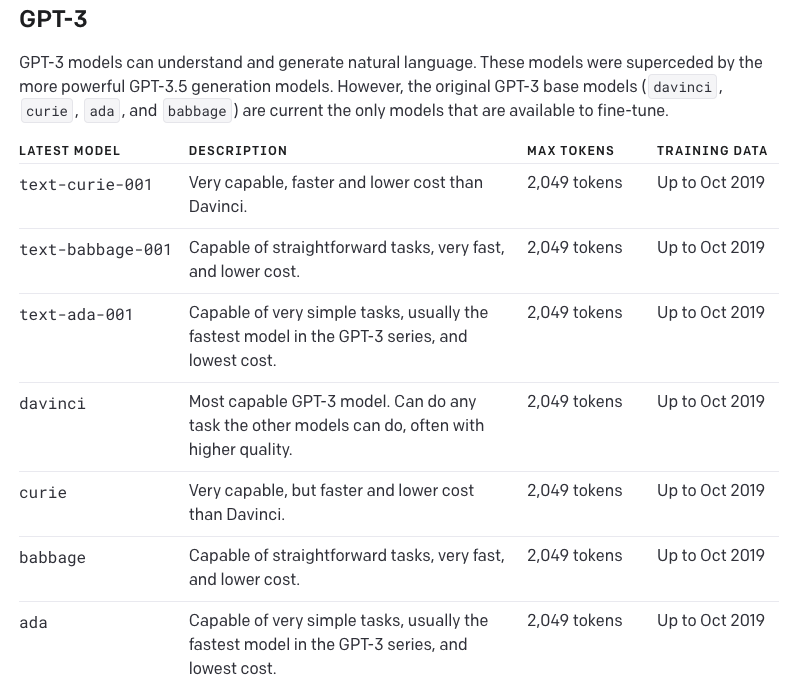